# Using Python and Data Science to Buy a Car
# Automating the process of finding good car deals with Python

Buying a car can be a troublesome activity. You need to constantly look up
dealerships websites to dig for good deals. Usually people spend a few months 
doing this before reaching a decision on which car to buy. A good option when it comes to used cars, usually involves considering things like, price range, mileage, the year in which the car was manufactured among other things.

I need to buy a car but I don't want to do any of that manually, so why not use 
a bit of Python magic with the help of an organized jupyter notebook and some webscraping to 
help me in the decision making process?

*In this article I will show you how to set up a webscraping and data analysis pipeline with Python and Jupyter Notebooks help with your car search*

---

# The Steps

To get started let's first define the steps of what we want to accomplish:

1. Define the target data
2. Scrape relevant data
3. Data cleaning and preprocessing
4. Data Analysis

The steps are straight forward, first we will define what we need (the target data),
then we will scrape the relevant data we want (its important to remember that the example I will show here will work on a specific website and you should change the scraping code to match the website you intend to scrape). Finally, we will do some data cleaning and preprocessing to be able to run data analysis smoothly, and to finish we will do data analysis on the data, visualizing information about the cars we might consider purchasing to help with reaching a decision.

---

## Define the target data

The data we want for this project will be:

- Price
- Car Brand and Model
- Car State (used or new)
- Car specs: 
  - Number of doors
  - Number of sits
  - Color
  - Power
  - Mileage
  - Fuel
  - Year

Once we have this data we will save it to a pandas dataframe and start the data cleaning stage.

## Scrape relevant data

To start, let's first define our imports.

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd 
import numpy as np

We will be using `beautifulsoup` and the `requests`packages for the webscraping, 
the `pandas` and `numpy` packages for all the necessary data processing once we have the data.

We start by first defining the website we want to scrape, in my case I will scrape information from a 
popular portuguese car dealership website.

In [26]:
website = 'https://www.santogal.pt/search-page/'

Now, we will write a function to scrape the data from the website, targeting the information we defined earlier.

In [4]:
# Turning everything into a function

def scrape_page(results):
    car_info = dict()
    for deal_index,result in enumerate(results):
        car_info[deal_index] = {}
        car_info[deal_index]["car_price"] = result.find('div', {"class": "price-container"}).get_text().strip()
        car_info[deal_index]["car_brand"] = result.find('h2').get_text().strip()
        car_info[deal_index]["car_model"] = result.find('h3').get_text().strip()
        car_info[deal_index]["car_state"] = result.find('header').get_text().strip()
        car_info[deal_index]["mileage"] = result.find('div', {"class": 'col-info-car'}).find_all('span')[0].get_text().strip()
        car_info[deal_index]["fuel"] = result.find('div', {"class": 'col-info-car'}).find_all('span')[2].get_text().strip()
        car_info[deal_index]["year"] = result.find_all('div', {"class": 'col-info-car'})[1].find_all('span')[0].get_text().strip()
    
    return car_info

Notice that for this example we scraped the car prices, mileage and fuel information from different `divs` found in the website search page, for the brand and model we had to find the `h2` and `h3` headers and similarly we used the `header` tag to find information about the car state (used or new), 
although this structure only works for this specific website, the differences between websites should not be too great so the adjustments necessary to have this working for your particular use case should not be too costly.

**Getting Car Specifications**

Now, for scraping more specific information about the cars like the number of doors and color,
we had to write a custom function that scrapes from each car deal url, meaning, for each 
car we had to access their respective url (within the website's search page) and scrape the specific information contained inside.

In [5]:
def get_car_specs(url):    
    """
    Function that scrapes the url for a specific car and gets more information 
    about the car, namely: number of doors, sits, color and horse power.
    """
    car_specs = dict()
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    characteristics_info = soup.find_all("dt")
    characteristics_data = soup.find_all("dd")
    for ch_info,ch_dt in zip(characteristics_info, characteristics_data):
        if ch_info.get_text().strip() == "Portas":
            car_specs["num_doors"] = ch_dt.get_text().strip()
        if ch_info.get_text().strip() == "Lugares":
            car_specs["num_sits"] = ch_dt.get_text().strip()
        if ch_info.get_text().strip() == "Cor":
            car_specs["color"] = ch_dt.get_text().strip()
        if ch_info.get_text().strip() == "Potência":
            car_specs["horse_power"] = ch_dt.get_text().strip()

    return car_specs

For this partciular case, I had to scrape the car's information from two different tags
`<dt>` and `<dd>` which are usually used for descriptions of items.

Once I found all of such tags I realized that the information was structured so that I could just run a for loop over the tags and get the desired characteristic by matching a string (in this case the words were in Portuguese).

**Running the main scraper function**

Now that I have two functions that can get all the information I desire, all I need to do is set up a for loop over all the available pages inside the main search page of the website.

In [27]:
try:
    website = 'https://www.santogal.pt/search-page/'
    response = requests.get(website)
    soup = BeautifulSoup(response.content, 'html.parser')
    num_pages = soup.find('div', {'class' : 'pagination_container'}).find("div", {"class": "last_page"}).get('data-page')
    num_pages = int(num_pages)
except ValueError:
    print("Something wrong with the scraping of the text,\
          not returning a number, setting page number to 59 manually")
    num_pages = 59
    
for i in range(1,num_pages):
    website = f"https://www.santogal.pt/search-page/?pagina={i}"
    response = requests.get(website)
    soup = BeautifulSoup(response.content, 'html.parser')
    results = soup.find_all('div', {'class' : 'card_car type--usado'})
    if len(results)>0:
        car_info = scrape_page(results)
        # get the link for each car found in the find_all output
        website_root = f"https://www.santogal.pt"
        for deal_index,result in enumerate(results):
            car_info[deal_index]["url"] = website_root+result.find('a').get('href')
        
        page_data = pd.DataFrame.from_dict(car_info, orient='index')
            
    if i==1:
        car_data = page_data 
    
    car_data = car_data.append(page_data, ignore_index=True)

What this function does is, first it discovers how many pages exist for us to scrape:

```
website = 'https://www.santogal.pt/search-page/'
response = requests.get(website)
soup = BeautifulSoup(response.content, 'html.parser')
num_pages = soup.find('div', {'class' : 'pagination_container'}).find("div", {"class": "last_page"}).get('data-page')
num_pages = int(num_pages)
```

and then, it uses the number of pages discovered to loop over each page, scraping the information
from it and appending it to a pandas dataframe.

Although this is a custom example for the website in question, I think the main structure here can be reused to any search page of your choice.

We can now take a look at the data we scraped.

In [28]:
car_data.head()

,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
0,24.990€,BMW,116 i Advantage,Usado,36.794 Kms,Gasolina,2018,https://www.santogal.pt/car-detail/bmw/serie-1...
1,42.490€\n39.990€,MERCEDES,A 45 AMG 4-Matic,Low Cost\n\nNovo Preço,29.064 Kms,Gasolina,2014,https://www.santogal.pt/car-detail/mercedes/cl...
2,22.990€,VOLVO,V40 1.5 T3 Sport Edition Geartr...,Usado,47.128 Kms,Gasolina,2018,https://www.santogal.pt/car-detail/volvo/v40/v...
3,28.490€,MINI,Cooper,Usado,37.506 Kms,Gasolina,2019,https://www.santogal.pt/car-detail/mini/mini/m...
4,19.500€\n18.490€,CITROEN,C4 Cactus 1.2 PureTech OneTone,Usado\n\nNovo Preço,62.003 Kms,Gasolina,2017,https://www.santogal.pt/car-detail/citroen/c4-...


All right, first part completed! Now that we have all the data we need, let's clean it to be able to run data analysis.

## Data cleaning and preprocessing

For this part we will need to set up a few custom functions that will handle common issues with data scraped from the internet, things like, string issues when numbers are mixed with other characters,
having commas instead of points among other things. 

Let's start with the price column.

In [7]:
def clean_price_data(price_data):
    if len(price_data.split('\n'))>1:
        return price_data.split('\n')[1].replace(".","").replace("€","").strip()
    else:
        return price_data.replace(".","").replace("€","").strip()
# only keep the car_price information after the \n string
car_data['car_price'] = car_data['car_price'].apply(clean_price_data).astype("int")
car_data.head()

,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
0,24990,BMW,116 i Advantage,Usado,36.794 Kms,Gasolina,2018,https://www.santogal.pt/car-detail/bmw/serie-1...
1,39990,MERCEDES,A 45 AMG 4-Matic,Low Cost\n\nNovo Preço,29.064 Kms,Gasolina,2014,https://www.santogal.pt/car-detail/mercedes/cl...
2,22990,VOLVO,V40 1.5 T3 Sport Edition Geartr...,Usado,47.128 Kms,Gasolina,2018,https://www.santogal.pt/car-detail/volvo/v40/v...
3,28490,MINI,Cooper,Usado,37.506 Kms,Gasolina,2019,https://www.santogal.pt/car-detail/mini/mini/m...
4,18490,CITROEN,C4 Cactus 1.2 PureTech OneTone,Usado\n\nNovo Preço,62.003 Kms,Gasolina,2017,https://www.santogal.pt/car-detail/citroen/c4-...


Here I am removing the euro sign from the price rows to be able to convert the column to
an integer type which will allow me to more easily visualize the price information.

In [8]:
def clean_state_info(state_info):
    if len(state_info.split('\n'))>1:
        return state_info.split('\n')[1]
    else:
        return state_info
# only keep the car_price information after the \n string
car_data['car_state'] = car_data['car_state'].apply(clean_state_info)
car_data["car_state"] = car_data["car_state"].apply(lambda x: np.nan if x=='' else x)
car_data.head()

,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
0,24990,BMW,116 i Advantage,Usado,36.794 Kms,Gasolina,2018,https://www.santogal.pt/car-detail/bmw/serie-1...
1,39990,MERCEDES,A 45 AMG 4-Matic,NaN,29.064 Kms,Gasolina,2014,https://www.santogal.pt/car-detail/mercedes/cl...
2,22990,VOLVO,V40 1.5 T3 Sport Edition Geartr...,Usado,47.128 Kms,Gasolina,2018,https://www.santogal.pt/car-detail/volvo/v40/v...
3,28490,MINI,Cooper,Usado,37.506 Kms,Gasolina,2019,https://www.santogal.pt/car-detail/mini/mini/m...
4,18490,CITROEN,C4 Cactus 1.2 PureTech OneTone,NaN,62.003 Kms,Gasolina,2017,https://www.santogal.pt/car-detail/citroen/c4-...


Here we remove some clutter from the `car_state` column to show only if the car is used or not,
in this case the word 'Usado' means used in portuguese.

In [29]:
def clean_mileage_info(mileage_info):
    return mileage_info.replace("Kms","").replace(".","").strip()
# only keep the car_price information after the \n string
car_data['mileage'] = car_data['mileage'].apply(clean_mileage_info).astype('int')
car_data.head()

,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
0,24.990€,BMW,116 i Advantage,Usado,36794,Gasolina,2018,https://www.santogal.pt/car-detail/bmw/serie-1...
1,42.490€\n39.990€,MERCEDES,A 45 AMG 4-Matic,Low Cost\n\nNovo Preço,29064,Gasolina,2014,https://www.santogal.pt/car-detail/mercedes/cl...
2,22.990€,VOLVO,V40 1.5 T3 Sport Edition Geartr...,Usado,47128,Gasolina,2018,https://www.santogal.pt/car-detail/volvo/v40/v...
3,28.490€,MINI,Cooper,Usado,37506,Gasolina,2019,https://www.santogal.pt/car-detail/mini/mini/m...
4,19.500€\n18.490€,CITROEN,C4 Cactus 1.2 PureTech OneTone,Usado\n\nNovo Preço,62003,Gasolina,2017,https://www.santogal.pt/car-detail/citroen/c4-...


Now, this function removes the `Kms` string from the mileage column, subsequently 
we turn that column into integer type just like in the price column for the same reasons.

In [32]:
# cleaning year data
car_data['year'] = pd.to_datetime(car_data['year']).dt.year

dtype('int64')

As for the year column we just turn it into integer (which is the output of the year attribute of the datetime object).

**Updating to CSV Car Database**

Now that our data is cleaned, we are ready to save it, since I had already done this before, I alrady had a csv file with the data I scraped, so here I will just be updating that file with the newly scraped data, for this part I am still considering which approach would be best to avoid issues like duplicates and changes to the website (like an old deal that is no longer available), but for now all I am doing is reading the local csv file, concatenating it with the newly scraped dataset and droping the duplicate entries. 

In [11]:
car_data_current = pd.read_csv("car_data.csv")
car_concat = pd.concat([car_data_current, car_data]).drop_duplicates().reset_index(drop=True)
print("Number of duplicates", car_concat.duplicated().sum())
print("Number of rows", len(car_concat))
car_concat.head()

Number of duplicates 0
Number of rows 1214


,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
0,24990,BMW,116 i Advantage,Usado,36794,Gasolina,2018,https://www.santogal.pt/car-detail/bmw/serie-1...
1,39990,MERCEDES,A 45 AMG 4-Matic,NaN,29064,Gasolina,2014,https://www.santogal.pt/car-detail/mercedes/cl...
2,22990,VOLVO,V40 1.5 T3 Sport Edition Geartr...,Usado,47128,Gasolina,2018,https://www.santogal.pt/car-detail/volvo/v40/v...
3,23990,MINI,Cooper S,Usado,34878,Gasolina,2015,https://www.santogal.pt/car-detail/mini/mini/m...
4,18490,CITROEN,C4 Cactus 1.2 PureTech OneTone,NaN,62003,Gasolina,2017,https://www.santogal.pt/car-detail/citroen/c4-...


And finally I save it to a csv file again.

In [12]:
car_concat.to_csv('car_data.csv', index=False)

## Data Analysis

Now, for this part we will be looking at information like, the cheapest cars, cars under a certain price,
and any other type of information that might be relevant when considering buying a used car on a tight budget. If you have any ideas of analysis I could do on this type of data please let me know in the comments!

**Loading the Data**

We start by importing some additional packages we will need for visualization as well as loading the data we just saved.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

car_data = pd.read_csv("car_data.csv")
car_data.head()

,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
0,24990,BMW,116 i Advantage,Usado,36794,Gasolina,2018,https://www.santogal.pt/car-detail/bmw/serie-1...
1,39990,MERCEDES,A 45 AMG 4-Matic,NaN,29064,Gasolina,2014,https://www.santogal.pt/car-detail/mercedes/cl...
2,22990,VOLVO,V40 1.5 T3 Sport Edition Geartr...,Usado,47128,Gasolina,2018,https://www.santogal.pt/car-detail/volvo/v40/v...
3,23990,MINI,Cooper S,Usado,34878,Gasolina,2015,https://www.santogal.pt/car-detail/mini/mini/m...
4,18490,CITROEN,C4 Cactus 1.2 PureTech OneTone,NaN,62003,Gasolina,2017,https://www.santogal.pt/car-detail/citroen/c4-...


Since I am only interested in cars I decided to write a function here to remove motocyles from the data,
since this is only for visualization purposes I decided to leave it here rather than at the data cleaning stage.

In [35]:
def remove_motos(x):
    if "moto" in x.lower():
        return False
    else:
        return True

car_data = car_data[car_data["car_brand"].apply(remove_motos)]
car_data.head()

,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
0,24990,BMW,116 i Advantage,Usado,36794,Gasolina,2018,https://www.santogal.pt/car-detail/bmw/serie-1...
1,39990,MERCEDES,A 45 AMG 4-Matic,NaN,29064,Gasolina,2014,https://www.santogal.pt/car-detail/mercedes/cl...
2,22990,VOLVO,V40 1.5 T3 Sport Edition Geartr...,Usado,47128,Gasolina,2018,https://www.santogal.pt/car-detail/volvo/v40/v...
3,23990,MINI,Cooper S,Usado,34878,Gasolina,2015,https://www.santogal.pt/car-detail/mini/mini/m...
4,18490,CITROEN,C4 Cactus 1.2 PureTech OneTone,NaN,62003,Gasolina,2017,https://www.santogal.pt/car-detail/citroen/c4-...


Now let's look at some statistics regarding car prices

Average and median of car prices

In [36]:
car_data["car_price"].mean()

29240.494587843463

In [37]:
car_data["car_price"].median()

23490.0

General statistics for about car prices

In [38]:
car_data["car_price"].describe()

count      1201.000000
mean      29240.494588
std       16434.262979
min        7990.000000
25%       18990.000000
50%       23490.000000
75%       33900.000000
max      189900.000000
Name: car_price, dtype: float64

Average price per car of a given year

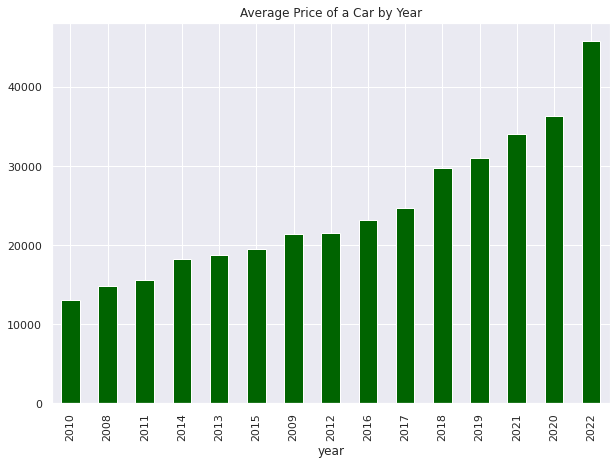

In [39]:
# plot average price of a car belonging to a given year

car_data.groupby("year")["car_price"].mean().sort_values().plot(kind='bar', color='darkgreen',
                                                  figsize=(10,7),
                                                  title="Average Price of a Car\
 by Year");

Now, since this is my first time buying a car I am not aware of what is the rate of devaluation for cars as the years go by, so I decided to look into that here. 

Now, how about the average car price for different brands? This could help me decide on the ideal car model given my budget.

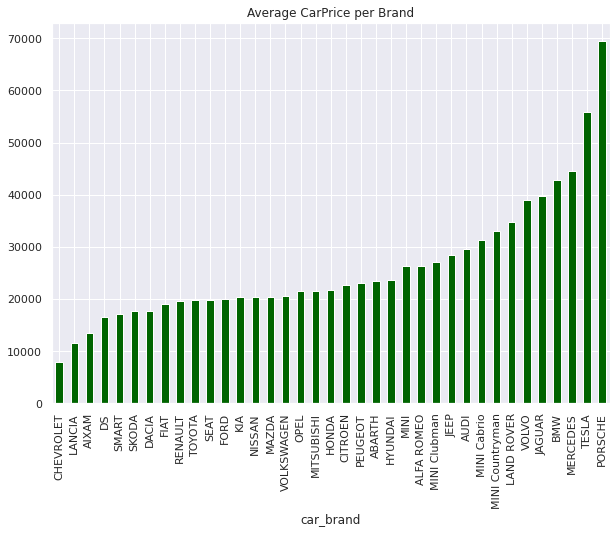

In [40]:
# Average car price per brand
car_data.groupby("car_brand")["car_price"].mean().sort_values().plot(kind='bar',
                                                                     color='darkgreen',
                                                                     figsize=(10,7),
                                                                     title="Average Car\
Price per Brand");

Now, I want to look at cars under a certain price to see which options come up.

In [19]:
# cars under 12000
car_data[car_data["car_price"]<12000]

,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
8,11990,HONDA,Civic 1.4 i-VTEC S.Edition,Low Cost,88586,Gasolina,2010,https://www.santogal.pt/car-detail/honda/civic...
80,11990,SMART,Forfour 0.9 Passion 90,NaN,73650,Gasolina,2015,https://www.santogal.pt/car-detail/smart/forfo...
86,9990,KIA,Rio 1.2 CVVT EX,Usado,114622,Gasolina,2013,https://www.santogal.pt/car-detail/kia/rio/rio...
94,11990,VOLKSWAGEN,Polo 1.2 TDi Trendline,Usado,101410,Diesel,2012,https://www.santogal.pt/car-detail/volkswagen/...
102,11990,SEAT,Ibiza SC 1.2 TDi Business,Usado,86738,Diesel,2015,https://www.santogal.pt/car-detail/seat/ibiza/...
128,11990,FIAT,Panda 1.2 Lounge S S,Usado,89466,Gasolina,2017,https://www.santogal.pt/car-detail/fiat/panda/...
131,10490,SKODA,Citigo 1.0 Ambition,Usado,83571,Gasolina,2015,https://www.santogal.pt/car-detail/skoda/citig...
133,7990,CHEVROLET,Spark 1.2 LT,Low Cost,53253,Gasolina,2010,https://www.santogal.pt/car-detail/chevrolet/s...
203,11600,SEAT,Altea XL 1.6 TDi Copa,Low Cost,116767,Diesel,2011,https://www.santogal.pt/car-detail/seat/altea/...
225,11490,LANCIA,Delta 1.6 M-Jet Gold,Usado,116817,Diesel,2013,https://www.santogal.pt/car-detail/lancia/delt...


In [20]:
# cars under 10000
car_data[car_data["car_price"]<10000]

,car_price,car_brand,car_model,car_state,mileage,fuel,year,url
86,9990,KIA,Rio 1.2 CVVT EX,Usado,114622,Gasolina,2013,https://www.santogal.pt/car-detail/kia/rio/rio...
133,7990,CHEVROLET,Spark 1.2 LT,Low Cost,53253,Gasolina,2010,https://www.santogal.pt/car-detail/chevrolet/s...
893,7990,FIAT,Panda 1.2 Lounge 118g,NaN,112017,Gasolina,2014,https://www.santogal.pt/car-detail/fiat/panda/...
1057,9990,KIA,Rio 1.2 CVVT EX,Usado,114687,Gasolina,2013,https://www.santogal.pt/car-detail/kia/rio/rio...
1193,7990,FIAT,Panda 1.2 Lounge 118g,Usado,112017,Gasolina,2014,https://www.santogal.pt/car-detail/fiat/panda/...
1197,8490,PEUGEOT,Metropolis,Usado,9,Gasolina,2022,https://www.santogal.pt/car-detail/peugeot/met...


Ok, as we can observe I was able to find quite a few viable options for under 12000 euros.

Now, I want to clean the data a bit more to get a more comprehensive number of car models.
I had to this because mistakes in describing the car model in the ad description can lead to 
the same model being considered different when running the data analysis, probably in the future if I streamline this analysis I will move this function to the data cleaning stage.

In [41]:
def clean_car_model(x):
    return " ".join(x.lower().split()[:3])

car_data["car_model_clean"] = car_data["car_model"].apply(clean_car_model)

len(car_data["car_model_clean"].unique())

455

Now, according to this, we have 455 different types of car models available to purchase, let's plot the average price for models of a given brand.

In [42]:
def plot_price_models_brand(car_data,brand_name):
    """
    Plot the average prices car models belonging to a given brand.
    """
    brand_models = car_data[car_data["car_brand"]==brand_name]["car_model_clean"].unique()
    avg_price_per_model = []
    for model in brand_models:
        avg_price_per_model.append(car_data[car_data["car_model_clean"]==model][
            "car_price"].mean())

    df = pd.DataFrame({"model":brand_models, "avg_price":avg_price_per_model})
    # plot sorted prices for each model
    df.sort_values("avg_price").plot(kind='bar', x="model", y="avg_price", 
                                    figsize=(10,7),color="darkgreen",
                                    title=f"Average Prices for {brand_name} Models");

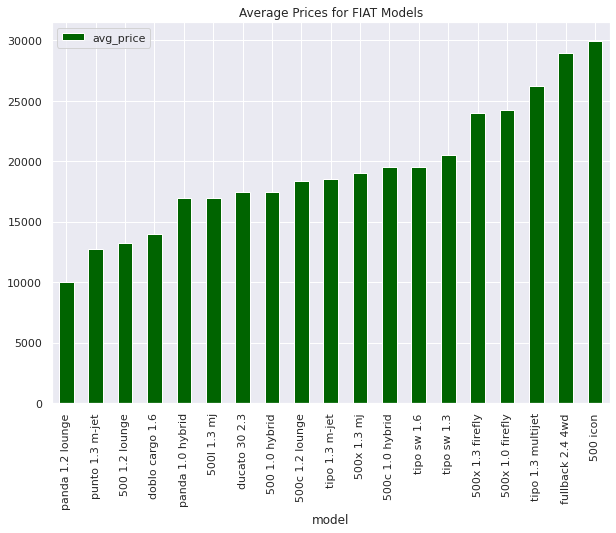

In [43]:
plot_price_models_brand(car_data,"FIAT")

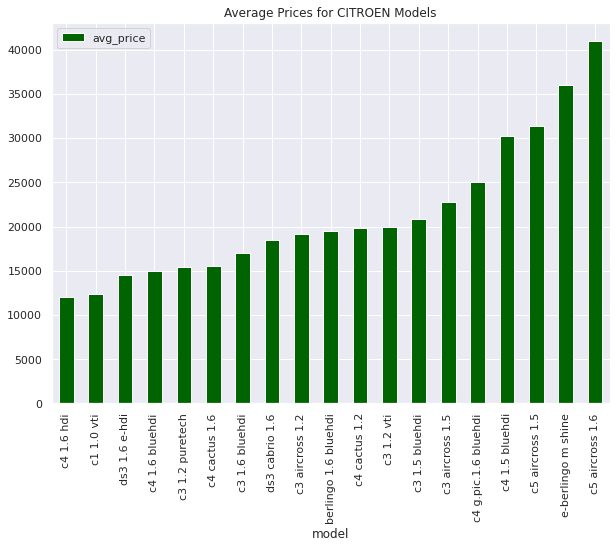

In [44]:
# plotting for citroen

plot_price_models_brand(car_data,'CITROEN')

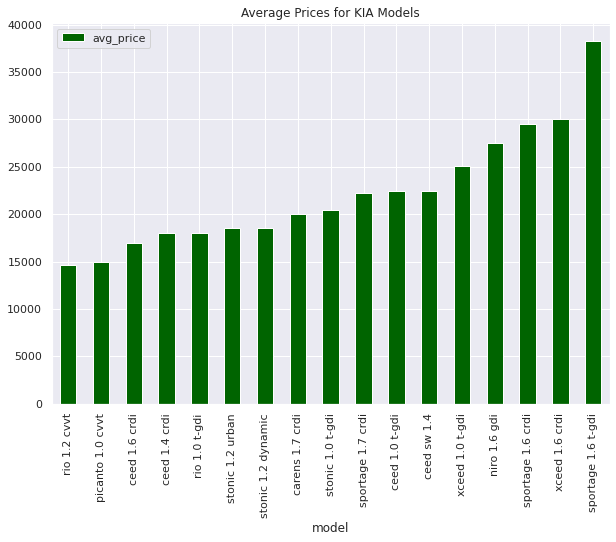

In [45]:
plot_price_models_brand(car_data, "KIA")

From these plots I see myself converging to models like the fiat lounge 1.2 or the citroen c1 vti.

Of course this is all preliminary and I should run more analysis before reaching any conclusions.


# Conclusion

For now I think I will stop here, this topic is infinite and one could spend hours doing all sorts of analysis on this data, which is something that I intend to do over the next few weeks so expect a new article soon with updates on this project!

If you liked this post, join Medium, follow, subscribe to my newsletter. Also, subscribe to my Youtube channel connect with me on Tiktok, Twitter, LinkedIn and Instagram! Thanks and see you next time! :)